**Возникшие вопросы**
   1. Почему в задании указано, что необходимо выбрать *датасеты*, а в примерах *бенчмарки*? При использовании бенчмарков теряется весь смысл задания, ведь они уже содержат множество датасетов и метрик с описаниями. 
   
**План проекта**
   1. Выбор датасетов:
   
   + Энкодер на проекте предполагается разработать *универсальный*, а значит датасеты должны быть мультиязычными, а также содержать языки малых народностей, и покрывать различные задачи работы с текстом.
   
   2. Определение метрик:
   
   + На основе выбранных датасетов выделить метрики проверки качества. 
   
<!--    + На тестовое задание даётся не так много времени, а значит  -->
   
   3. Выбор подходов для сравнения:
   
   + Постановка гипотез, относительно итогового качества моделей и выделение задач, на которых каждая из моделей должна показать хороший результат.
   + Выбираем для экспериментов только предобученные модели, получаем zero-shot эмбеддинги на выбранных данных.
   + Делаем выводы по гипотезам, строим таблицы с результатами.

**Датасеты:**
+ Параллельный перевод для удмуртского языка (как языка малой народности) [UDM](https://huggingface.co/datasets/udmurtNLP/flores-250-rus-udm).
+ Парафразы [PAR](https://huggingface.co/datasets/merionum/ru_paraphraser)
+ Всегда актуальная токсичность [TOX](https://huggingface.co/datasets/FredZhang7/toxi-text-3M). Я выбрал именно этот датасет, так как он содержит 50+ языков, и это наибльшая выборка для этой задачи, которую я сумел найти. В ней слишком много английского, турецкого и арабского. Ограничиваюсь 20000 семплов сверху и 500 снизу дня каждого языка. Сверху, чтобы я успел провести эксперименты, а снизу, чтобы рассчеты среднего по языкам были более репрезентативны.
+ Суммаризация [SUM](https://huggingface.co/datasets/embedding-data/sentence-compression). В этом датасете тексты относительно небольшие и не требуют больших вычислительных мощностей.
+ Мультиклассовая классификация [MGP](https://huggingface.co/datasets/datadrivenscience/movie-genre-prediction).

**Метрики**
+ *UDM* - косинусная близость русских и удмуртских эмбеддингов.
+ *SUM* - косинусная близость эмбеддингов текста и краткого изложения.
+ *TOX* - произведение средней точности KNN (с параметрами **#TBD#**) и энтропии точностей по языкам.
+ *MGP* - f1_score macro на предсказания KNN.

**Подходы:**
+ Word2Vec / что-то еще такое самое простое
+ T5-flan [google/flan-t5-small](https://huggingface.co/google/flan-t5-small)  Использую усреднение эмбеддингов энкодера, так как в [этой статье](https://arxiv.org/abs/2108.08877) такой подход показал лучший результат для zero-shot.
+ Instructor
+ multilingual-e5-small
+ sentence-transformers/all-MiniLM-L6-v2



In [11]:
from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [178]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, BertTokenizerFast, BertModel
from torch import nn
from datasets import load_dataset
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
from InstructorEmbedding import INSTRUCTOR
from abc import abstractmethod

DEVICE = 'cuda'

class AbstractModelProcesssor:
#     @abstractmethod
#     def get_sentences(self, dataset_processor, i):
#         pass
    @abstractmethod
    def __init__(self, model, tokenizer=None):
        pass

    def get_sentences(self, dataset_processor, i):
        sample = dataset_processor.get_sample(i)
        if 'text_2' in sample.keys():
            sentences = sample['text_1'], sample['text_2']
        else:
            sentences = sample['text_1']
        return sentences
    
    @abstractmethod
    def get_embeddings(self, sentences):
        pass

'''
'''
class T5ModelProcessor(AbstractModelProcesssor):
    def __init__(self, model, tokenizer):
        self.__model = model
        self.__tokenizer = tokenizer
    
    def get_embeddings(self, sentences):
        enc = self.__tokenizer(sentences, \
                               max_length=512, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
        outputs = self.__model.encoder(**enc)
        embeddings = average_pool(outputs.last_hidden_state, enc['attention_mask'].to(DEVICE))
        return embeddings


'''
'''
class E5ModelProcessor(AbstractModelProcesssor):
    def __init__(self, model, tokenizer):
        self.__model = model
        self.__tokenizer = tokenizer
        
    def get_embeddings(self, sentences):
        enc = self.__tokenizer(sentences, \
                               max_length=512, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
        outputs = self.__model(**enc)
        embeddings = average_pool(outputs.last_hidden_state, enc['attention_mask'].to(DEVICE))
        return embeddings
    
'''
'''
class LabseModelProcessor(AbstractModelProcesssor):
    def __init__(self, model, tokenizer):
        self.__model = model
        self.__tokenizer = tokenizer
        
    def get_embeddings(self, sentences):
        enc = self.__tokenizer(sentences, \
                           max_length=512, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
        outputs = self.__model(**enc)
        embeddings = outputs.pooler_output
        return embeddings

'''
'''
class MinilmModelProcessor(AbstractModelProcesssor):  
    def __init__(self, model):
        self.__model = model
        
    def get_embeddings(self, sentences):
        embeddings = self.__model.encode(sentences, device=DEVICE)
        embeddings = torch.tensor(embeddings)
        return embeddings

'''
'''
class InstructorModelProcessor(AbstractModelProcesssor):
    def __init__(self, model):
        self.__model = model
        
    def get_embeddings(self, sentences):
        embeddings = self.__model.encode(sentences, device=DEVICE)
        embeddings = torch.tensor(embeddings)
        return embeddings


'''
'''
class GloveModelProcessor(AbstractModelProcesssor):
    def __init__(self, model):
        self.__model = model
        
    def get_embeddings(self, sentences):
        embeddings = [self.__model.get_mean_vector(sentence) for sentence in sentences]
        embeddings = torch.tensor(embeddings)
        return embeddings

    
    
def get_cosine_sim(embeddings):
    cosine_similarity = nn.CosineSimilarity()
    cosine_sim = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))
    return cosine_sim.cpu().detach().numpy()


# def calculate_UDM(model_name: str):

#     dataset = load_dataset("data/flores-250-rus-udm/")
#     results = []
    
#     if model_name == 'flan-t5-small':
#         tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
#         model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").cuda()
        
#         for i in range(len(dataset['sentences']['rus'])):
#             sentences = dataset['sentences']['rus'][i], dataset['sentences']['udm'][i]
#             embeddings = get_embeddings_t5(tokenizer, model, sentences)
#             cosine_sim = get_cosine_sim_2(embeddings)
#             results.append(cosine_sim)
        
#     elif model_name == 'multilingual-e5-small':
#         tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
#         model = AutoModel.from_pretrained('intfloat/multilingual-e5-small').cuda()

#         for i in range(len(dataset['sentences']['rus'])):
#             sentences = dataset['sentences']['rus'][i], dataset['sentences']['udm'][i]
#             embeddings = get_embeddings_e5(tokenizer, model, sentences)
#             cosine_sim = get_cosine_sim_2(embeddings)
#             results.append(cosine_sim)
            
#     elif model_name == 'LaBSE':
#         tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
#         model = BertModel.from_pretrained("setu4993/LaBSE").cuda()

#         for i in range(len(dataset['sentences']['rus'])):
#             sentences = dataset['sentences']['rus'][i], dataset['sentences']['udm'][i]
#             embeddings = get_embeddings_labse(tokenizer, model, sentences)
#             cosine_sim = get_cosine_sim_2(embeddings)
#             results.append(cosine_sim)

#     elif model_name == 'all-MiniLM-L6-v2':
#         model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#         for i in range(len(dataset['sentences']['rus'])):
#             sentences = dataset['sentences']['rus'][i], dataset['sentences']['udm'][i]

#             embeddings = get_embeddings_minilm(sentences)
#             cosine_sim = get_cosine_sim_2(embeddings)
#             results.append(cosine_sim)

#     elif model_name == 'instructor_base':
#         model = INSTRUCTOR('hkunlp/instructor-base')

#         for i in range(len(dataset['sentences']['rus'])):
#             sentences = dataset['sentences']['rus'][i], dataset['sentences']['udm'][i]
#             embeddings = get_embeddings_instructor(sentences)
#             cosine_sim = get_cosine_sim_2(embeddings)
#             results.append(cosine_sim)
        
#     elif model_name == 'glove-twitter-25':
#         glove_vectors = gensim.downloader.load('glove-twitter-25')
        
#         for i in range(len(dataset['sentences']['rus'])):
#             sentence_1 = dataset['sentences']['rus'][i].lower().split(' ')
#             sentence_2 = dataset['sentences']['udm'][i].lower().split(' ')
#             sentences = [sentence_1, sentence_2]
#             embeddings = get_embeddings_glove(sentences)
#             cosine_sim = get_cosine_sim(embeddings)
#             results.append(cosine_sim)
        
#     return np.mean(results)


# print(calculate_UDM('flan-t5-small'))
# print(calculate_UDM('multilingual-e5-small'))
# calculate_UDM('all-MiniLM-L6-v2')
# calculate_UDM('instructor_base')
# calculate_UDM('LaBSE')
# calculate_UDM('glove-twitter-25')

In [142]:
from tqdm.notebook import tqdm

# model = INSTRUCTOR('hkunlp/instructor-base')
# tokenizer = None

# tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
# model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(DEVICE)
# model_processor = T5ModelProcessor()

tokenizer = None
model = gensim.downloader.load('glove-twitter-25')
model_processor = GloveModelProcessor()


dataset_processor = ParaphraserDatasetProcessor()

def calculate_PAR(model_processor, dataset_processor, model, tokenizer=None):
    results = []
    
    for i in tqdm(range(len(dataset_processor))):
        sentences = model_processor.get_sentences(dataset_processor, i)
        label = dataset_processor.get_sample(i)['class']
        if label != 0:
            embeddings = model_processor.get_embeddings(sentences, model, tokenizer)
            cosine_sim = get_cosine_sim(embeddings) if label == 1 else 1 - get_cosine_sim(embeddings)
            results.append(cosine_sim)
        
    return np.mean(results)

calculate_PAR(model_processor, dataset_processor, model, tokenizer)

/tmp/ipykernel_272999/1200310005.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(dataset_processor))):


  0%|          | 0/7227 [00:00<?, ?it/s]

0.10143024

In [146]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(DEVICE)

model_processor = T5ModelProcessor(model, tokenizer)
dataset_processor = FloresDatasetProcessor()

def calculate_UDM(model_processor, dataset_processor):
    results = []
    
    for i in range(len(dataset_processor)):
        sentences = model_processor.get_sentences(dataset_processor, i)
        embeddings = model_processor.get_embeddings(sentences)
        cosine_sim = get_cosine_sim(embeddings)
        results.append(cosine_sim)
        
    return np.mean(results)

calculate_UDM(model_processor, dataset_processor)

0.87386423

In [ ]:
# def calculate_TOX(model_processor, dataset_processor):
#     results = []
    
#     for i 

In [168]:
from tqdm.notebook import tqdm

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(DEVICE)

model_processor = T5ModelProcessor(model, tokenizer)
dataset_processor = SummDatasetProcessor()

def calculate_SUM(model_processor, dataset_processor, k=100):
    results = []
    
    for i in tqdm(range(min(len(dataset_processor), k))):
        sentences = model_processor.get_sentences(dataset_processor, i)
        embeddings = model_processor.get_embeddings(sentences)
        cosine_sim = get_cosine_sim(embeddings)
        results.append(cosine_sim)
        
    return np.mean(results)

calculate_SUM(model_processor, dataset_processor)

  0%|          | 0/100 [00:00<?, ?it/s]

0.7138985

In [205]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(DEVICE)

model_processor = T5ModelProcessor(model, tokenizer)
dataset_processor = MGPDatasetProcessor()

def calculate_MGP(model_processor, dataset_processor, k=1000):
    results = []
    labels = dataset_processor.get_labels()
    
    for i in tqdm(range(min(len(dataset_processor), k))):
        sentences = model_processor.get_sentences(dataset_processor, i)
        embeddings = model_processor.get_embeddings(sentences)
        results.append(embeddings.flatten().cpu().detach().numpy())
        
    return results, labels
    
results, labels = calculate_MGP(model_processor, dataset_processor)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.78 GiB total capacity; 6.49 GiB already allocated; 3.62 MiB free; 7.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [200]:
X = torch.vstack(results).cpu().detach().numpy()

In [202]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mo

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, labels[:100])

KNeighborsClassifier()

In [203]:
clf.predict(X)

array(['adventure', 'adventure', 'scifi', 'scifi', 'action', 'action',
       'crime', 'action', 'adventure', 'mystery', 'crime', 'horror',
       'scifi', 'action', 'action', 'action', 'scifi', 'action',
       'adventure', 'family', 'crime', 'horror', 'adventure', 'action',
       'adventure', 'action', 'crime', 'crime', 'scifi', 'crime',
       'action', 'action', 'crime', 'adventure', 'action', 'crime',
       'family', 'fantasy', 'crime', 'adventure', 'family', 'family',
       'adventure', 'crime', 'action', 'mystery', 'action', 'thriller',
       'crime', 'scifi', 'fantasy', 'family', 'action', 'crime', 'action',
       'horror', 'crime', 'fantasy', 'horror', 'fantasy', 'action',
       'crime', 'crime', 'family', 'action', 'scifi', 'action', 'action',
       'action', 'action', 'family', 'crime', 'adventure', 'scifi',
       'crime', 'family', 'action', 'horror', 'action', 'horror',
       'action', 'horror', 'adventure', 'action', 'scifi', 'adventure',
       'adventure', 'rom

In [182]:
from abc import abstractmethod

class AbstractDatasetProcessor:
    @abstractmethod
    def get_sample(i: int):
        pass
    
'''
flores-250-rus-udm
'''
class FloresDatasetProcessor(AbstractDatasetProcessor):
    def __init__(self):
        dataset = load_dataset("data/flores-250-rus-udm/")
        self.__dataset = dataset['sentences']
        self.__len = len(self.__dataset)
        
    def __len__(self):
        return self.__len
    
    def get_sample(self, i: int):
        if i < 0 or i >= len(self):
            return None
        
        sample = {
            'text_1': self.__dataset['rus'][i],
            'text_2': self.__dataset['udm'][i]
        }
        
        return sample
        
'''
ru_paraphraser
'''  
class ParaphraserDatasetProcessor(AbstractDatasetProcessor):
    def __init__(self):
        dataset = load_dataset("data/ru_paraphraser/")
        self.__dataset = dataset['train']
        self.__len = len(self.__dataset)
        
    def __len__(self):
        return self.__len
    
    def get_sample(self, i: int):
        if i < 0 or i >= len(self):
            return None
        
        sample = {
            'text_1': self.__dataset['text_1'][i],
            'text_2': self.__dataset['text_2'][i],
            'class': self.__dataset['class'][i]
        }
        
        return sample
  

'''
toxi-text-3M
'''
class ToxiDatasetProcessor(AbstractDatasetProcessor):
    def __init__(self):
        dataset = load_dataset("data/toxi-text-3M/train/")
        self.__dataset = dataset['train']
        self.__len = len(self.__dataset)
        
    def __len__(self):
        return self.__len
    
    def get_sample(self, i: int):
        if i < 0 or i >= len(self):
            return None
        
        sample = {
            'text': self.__dataset['text'][i],
            'is_toxic': self.__dataset['is_toxic'][i],
            'lang': self.__dataset['lang'][i]
        }
        
        return sample
    
class SummDatasetProcessor(AbstractDatasetProcessor):
    def __init__(self):
        dataset = load_dataset("data/sentence-compression/")
        self.__dataset = dataset['train']
        self.__len = len(self.__dataset)
        
    def __len__(self):
        return self.__len
    
    def get_sample(self, i: int):
        if i < 0 or i >= len(self):
            return None
        
        sample = {
            'text_1': self.__dataset['set'][i][0],
            'text_2': self.__dataset['set'][i][1],
        }
        
        return sample
    
    
class MGPDatasetProcessor(AbstractDatasetProcessor):
    def __init__(self):
        dataset = load_dataset("data/movie-genre-prediction/data")
        self.__dataset = dataset['train']
        self.__len = len(self.__dataset)
        
    def __len__(self):
        return self.__len
    
    def get_sample(self, i: int):
        if i < 0 or i >= len(self):
            return None
        
        sample = {
            'text_1': self.__dataset['synopsis'][i],
            'label': self.__dataset['genre'][i] 
        }
        
        return sample
    
    def get_labels(self):
        return self.__dataset['genre']

In [162]:
test = SummDatasetProcessor()
test.get_sample(1)

{'text': 'Major League Baseball Commissioner Bud Selig will be speaking at St. Norbert College next month.',
 'summary': 'Bud Selig to speak at St. Norbert College'}

In [171]:
dataset = load_dataset('data/movie-genre-prediction/data/')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [176]:
dataset['train']['genre']

['fantasy',
 'horror',
 'family',
 'scifi',
 'action',
 'horror',
 'horror',
 'crime',
 'adventure',
 'mystery',
 'mystery',
 'horror',
 'horror',
 'action',
 'action',
 'action',
 'scifi',
 'action',
 'mystery',
 'family',
 'crime',
 'horror',
 'fantasy',
 'action',
 'action',
 'action',
 'mystery',
 'crime',
 'crime',
 'adventure',
 'family',
 'scifi',
 'romance',
 'scifi',
 'crime',
 'fantasy',
 'family',
 'romance',
 'fantasy',
 'adventure',
 'family',
 'family',
 'adventure',
 'mystery',
 'crime',
 'mystery',
 'crime',
 'thriller',
 'mystery',
 'scifi',
 'mystery',
 'family',
 'action',
 'family',
 'crime',
 'horror',
 'fantasy',
 'fantasy',
 'horror',
 'family',
 'action',
 'crime',
 'thriller',
 'family',
 'action',
 'mystery',
 'action',
 'action',
 'action',
 'scifi',
 'family',
 'scifi',
 'adventure',
 'scifi',
 'fantasy',
 'family',
 'action',
 'thriller',
 'crime',
 'romance',
 'mystery',
 'crime',
 'fantasy',
 'fantasy',
 'adventure',
 'scifi',
 'adventure',
 'romance',
 '

In [37]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [52]:
from torch import nn

cosine_sim = nn.CosineSimilarity()

In [56]:
cosine_sim(emb, emb)

tensor([1.0000], device='cuda:1', grad_fn=<SumBackward1>)

In [89]:
import numpy as np
import matplotlib.pyplot as plt


names, counts = np.unique(dataset['train']['lang'], return_counts=True)
order = np.argsort(counts)
names, counts = names[order], counts[order]

KeyError: 'train'

/home/boris/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/boris/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/boris/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


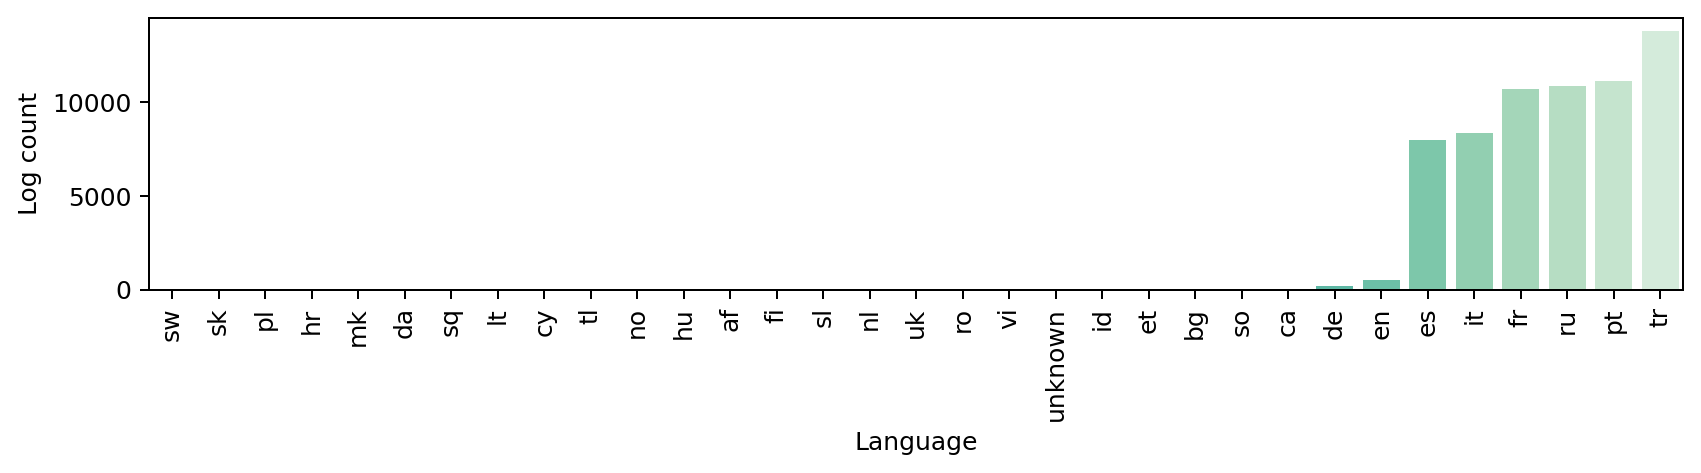

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(11,2), dpi=180)

ax = sns.barplot(x=names, y=counts, palette='mako')
# plt.title('Average f1_score macro', fontsize=14)
# plt.yticks([])
plt.ylabel('Log count')
plt.xlabel('Language')
plt.xticks(rotation=90)
plt.show()

In [117]:
np.sum(counts)

2880667

In [96]:
counts[np.argsort(counts)]

array([      1,       3,       3,       3,       6,       9,      15,
            29,      29,      48,      49,     118,     138,     140,
           185,     235,     319,     376,     555,     609,     705,
           754,     883,     894,    1010,    1019,    1255,    1300,
          1600,    1762,    2117,    2167,    2217,    2886,    3316,
          3428,    3621,    3642,    3904,    3922,    4441,    5343,
          5540,    5826,    5911,   10313,   12255,   17834,   20611,
         24921,   26175,   26726,   39634,   50543,   51320, 2528002])

In [109]:
ax.containers[0].patches[-1].set_y(100)

In [88]:
np.e**14

1202604.2841647759

In [79]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
speechbrain 0.5.13 requires torchaudio, which is not installed.


In [33]:
dataset['train']['text_1'][:9]

['Полицейским разрешат стрелять на поражение по гражданам с травматикой.',
 'Право полицейских на проникновение в жилище решили ограничить.',
 'Президент Египта ввел чрезвычайное положение в мятежных городах.',
 'Вернувшихся из Сирии россиян волнует вопрос трудоустройства на родине.',
 'В Москву из Сирии вернулись 2 самолета МЧС с россиянами на борту.',
 'Приставы соберут отпечатки пальцев российских должников.',
 'На саратовского дебошира с борта самолета Москва - Хургада заведено дело.',
 'ЦИК хочет отказаться от электронной системы подсчета голосов.',
 'Суд Петербурга оставил на потом дело о гибели подростка в полиции.']

In [133]:
!pip install InstructorEmbedding

Defaulting to user installation because normal site-packages is not writeable


In [23]:
from InstructorEmbedding import INSTRUCTOR
model = INSTRUCTOR('hkunlp/instructor-base')

load INSTRUCTOR_Transformer
max_seq_length  512


In [29]:
res = model.encode(['qweqwe', 'qweqwe'],
          batch_size=32,
          show_progress_bar=True,
                   device='cuda')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
res.shape

(2, 768)

In [2]:
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = ['query: how much protein should a female eat',
               'query: 南瓜的家常做法']

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-small')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())

[[], []]


In [10]:
output = model(
    input_ids=batch_dict["input_ids"].cuda(), 
    attention_mask=batch_dict["attention_mask"].cuda(), 
    return_dict=True
)

In [16]:
output.last_hidden_state.shape
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
embeddings

tensor([[ 0.2113, -0.1942, -0.2871, -0.2428,  0.6063, -0.2187,  0.1692,  0.2813,
          0.4607, -0.0746,  0.1920,  0.1253,  0.2205, -0.1990, -0.2133,  0.3346,
          0.3233, -0.2749, -0.1612, -0.5109, -0.0448,  0.0592, -0.3491,  0.4011,
          0.4356,  0.1737,  0.2751, -0.0773,  0.1615, -0.2952, -0.3020, -0.2176,
          0.3351, -0.1934,  0.2283,  0.0232, -0.3328, -0.0801,  0.3951, -0.3215,
          0.0586,  0.3682,  0.0729,  0.1881,  0.1667,  0.1760, -0.2040,  0.2159,
          0.1377, -0.0920, -0.2667,  0.2398,  0.1658,  0.1980,  0.2513, -0.2338,
         -0.2937, -0.2552, -0.3896, -0.0398,  0.2916, -0.3015, -0.0244,  0.0466,
          0.3411,  0.2605,  0.0544,  0.0060, -0.3516, -0.1419, -0.3401,  0.2253,
          0.0410, -0.1107,  0.1974, -0.0136,  0.2216, -0.2618, -0.0146, -0.1631,
         -0.5415, -0.2445, -0.2729,  0.0537, -0.2405,  0.2793,  0.2719, -0.4340,
          0.2677, -0.1420,  0.1342,  0.0133, -0.2017, -0.2481, -0.1571, -0.2807,
         -0.1654,  0.3177,  

In [19]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[[ 6.76568672e-02  6.34958968e-02  4.87131178e-02  7.93049783e-02
   3.74480784e-02  2.65279436e-03  3.93749662e-02 -7.09845778e-03
   5.93614243e-02  3.15370187e-02  6.00981005e-02 -5.29051833e-02
   4.06067930e-02 -2.59308629e-02  2.98428163e-02  1.12690870e-03
   7.35148787e-02 -5.03819287e-02 -1.22386612e-01  2.37028636e-02
   2.97265444e-02  4.24768962e-02  2.56337821e-02  1.99516886e-03
  -5.69190867e-02 -2.71597803e-02 -3.29035781e-02  6.60248548e-02
   1.19007140e-01 -4.58791442e-02 -7.26214945e-02 -3.25839855e-02
   5.23413904e-02  4.50553074e-02  8.25301651e-03  3.67024243e-02
  -1.39415171e-02  6.53919280e-02 -2.64272410e-02  2.06390221e-04
  -1.36643331e-02 -3.62810045e-02 -1.95043627e-02 -2.89738458e-02
   3.94270420e-02 -8.84091109e-02  2.62419810e-03  1.36713954e-02
   4.83062677e-02 -3.11565809e-02 -1.17329203e-01 -5.11690229e-02
  -8.85287896e-02 -2.18962301e-02  1.42986560e-02  4.44167890e-02
  -1.34815350e-02  7.43392482e-02  2.66382601e-02 -1.98762454e-02
   1.79191